# 6 - Selección de Características mediante Clustering

Como problema de partida de ejemplo de como aplicar diferentes algoritmos de clustering vamos a utilizar unos datos del Producto Interior Bruto de los Estados de Estados Unidos en 2009. Los datos están en [Enlace](https://drive.google.com/open?id=1Rb_7eNacmktJM3RqETQmSLysXYjk5EDG)

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from numpy import corrcoef, transpose, arange
from pylab import pcolor, show, colorbar, xticks, yticks

## Carga de Datos

En primer lugar cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab

In [17]:
# 0.1 load data from file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 2009pivot.csv to 2009pivot (1).csv
User uploaded file "2009pivot (1).csv" with length 5329 bytes


Posteriormente utilizamos la librería [Pandas](https://pandas.pydata.org/) con el fin de poder manejar los datos en una estructura denominada DataFrame. Además, con el objetivo de analizar las características con este estudio de aprendizaje no supervisado, **vamos a transponer el dataset**, de modo que las características originales serán ahora los nuevos "elementos" y los elementos originales las nuevas "características".


In [18]:
# 0.2 load data in DataFrame
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col='State')
df_feat = transpose(df)
df_feat

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Agriculture,2040,305,1528,2537,25439,2112,314,276,2,5458,...,3124,1386,5964,357,263,1476,5559,186,3089,401
Mining,2982,14327,4687,2249,20279,11330,113,1,0,1278,...,152,1173,119695,3425,223,2463,687,7502,548,13165
Utilities,4965,612,5677,2467,27999,3152,3998,868,1372,16011,...,612,1611,24497,1481,596,6316,3575,1842,4664,822
Construction,7866,2143,13167,4266,65707,11612,6989,1750,1011,35659,...,1470,9072,61603,5954,1030,15999,15077,2723,9205,1906
Manufacturing,25444,1867,20026,14010,229479,19429,27665,4732,238,38284,...,3184,38465,153204,15609,2632,36951,47518,6775,45247,1624
Wholesale trade,9712,1026,14283,7257,100603,13309,12795,2258,828,47080,...,2242,16434,80764,5711,1168,16413,18767,2932,14446,1307
Retail,12287,1943,18439,7070,109363,14140,11314,2423,1078,53163,...,2517,18257,68416,7875,2005,21234,22183,4488,14753,1956
Transportation,4471,4510,6859,4120,41864,6386,4123,752,325,21177,...,890,11202,39577,3740,484,9661,9294,1956,6961,2238
Information,4244,948,6559,10864,134655,20171,12134,1210,8073,29121,...,934,7900,41877,4214,683,16299,32180,1441,7949,449
Finance,25185,5416,51282,14879,406685,45343,69118,23162,11226,161861,...,9755,39924,167303,22879,4973,75490,63201,7935,49183,4233


Estos datos contienen para cada uno de los estados (*State*) las diferentes cantidades en producto interior bruto dentro de categorías que denominaríamos de nivel 2 de agregación, es decir, son una desagragción de niveles superiores. De esta forma encontramos datos como el PIB de Agricultura, Minería, Construcción, Comercio, etc.

Una vez que contamos con el DataFrame de Pandas podríamos analizar qué características necesitamos y cuales deberíamos excluir.

In [19]:
names =  df_feat.index
names

Index(['Agriculture', 'Mining', 'Utilities', 'Construction', 'Manufacturing',
       'Wholesale trade', 'Retail', 'Transportation', 'Information', 'Finance',
       'Buss. Services', 'Education', 'Arts', 'Oth Serv.', 'Fed. civ',
       'Fed. military', 'State.1'],
      dtype='object')

# Correlación entre variables

Con el fin de que obtener un mejor rendimiento en el algoritmo de clustering será necesario identificar aquellas variables que son redundantes, es decir, se puede asumir que representan lo mismo, en este caso se puede utilizar el análisis de correlaciones.

<Axes: >

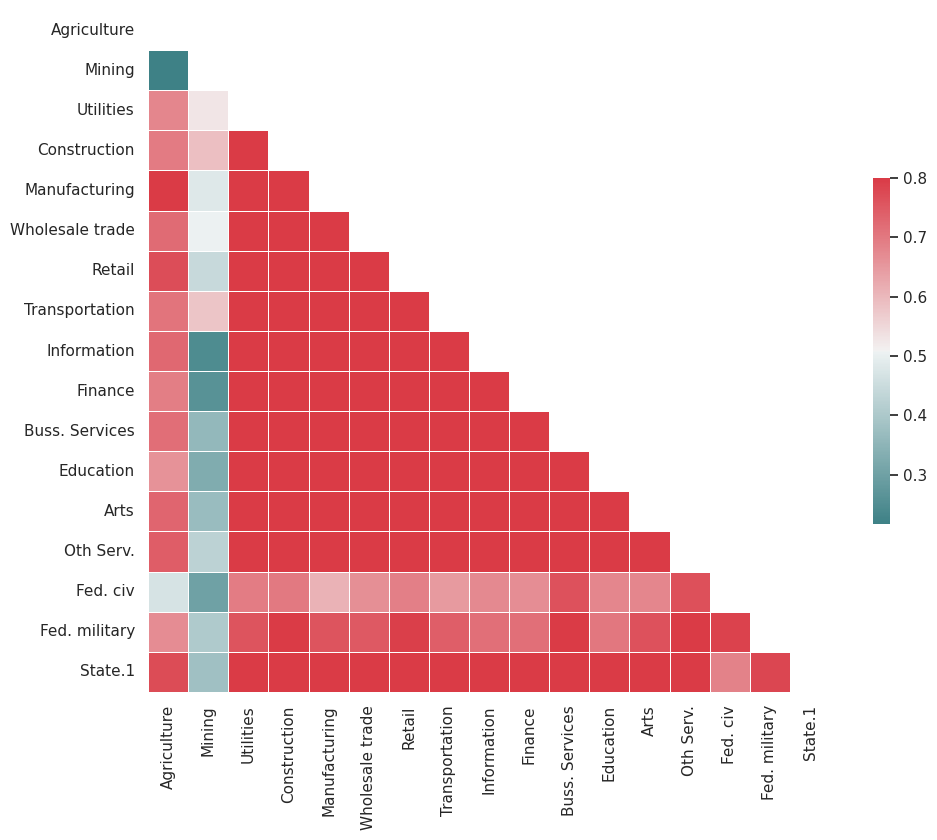

In [20]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html
R = corrcoef(df_feat)

# http://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(R, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names, yticklabels=names,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Las variables están correlacionadas entre ellas, pero no demasiado (no llega a 1) esto puede hacer que las sigamos teniendo en cuenta aunque hay que ser consciente que algunas de ellas pueden ser muy parecidas.

# Análisis de componentes principales

Con el fin de observar como están relacionadas las variables también podemos hacer una representación en PCA de las mismas


Componentes lineales:
 [[ 0.17471974  0.01691705  0.13628741  0.16189635  0.14836261  0.13424342
   0.13024719  0.11654945  0.03037342  0.12548595  0.14008045  0.09641172
   0.15422895  0.14648155  0.11837923  0.15223106  0.17434102  0.16185584
   0.12050914  0.14709379  0.12233627  0.14376664  0.17066183  0.1540942
   0.17546393  0.15201328  0.1197977   0.13984577  0.10868086  0.14453456
   0.14000405  0.13355947  0.12372454  0.15080806  0.12229149  0.16650496
   0.14405945  0.1295242   0.15683835  0.12991936  0.16387308  0.1135697
   0.17536626  0.14908159  0.14351173  0.15090339  0.14299045  0.14885547
   0.1440164   0.16502078  0.01374865]
 [-0.07567358 -0.2707411   0.078352   -0.03816222  0.0709091   0.09448204
   0.08795315  0.11219413  0.33836245  0.14811725  0.08539428  0.19968214
   0.01503688  0.06767808 -0.14697313 -0.07854205 -0.06276295 -0.15337366
  -0.29201272  0.05005887  0.20863424  0.13115975  0.00484791  0.03867246
  -0.13895243  0.05629989  0.02973841  0.01214712  0

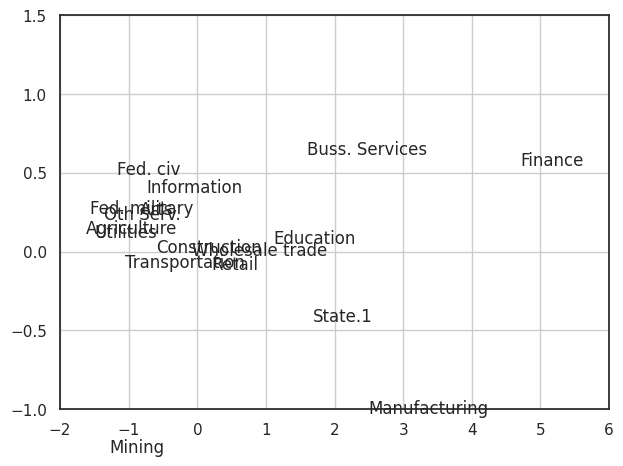

In [21]:
#1. Normalization of the data
#http://scikit-learn.org/stable/modules/preprocessing.html
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
features_norm = min_max_scaler.fit_transform(df_feat)

#1.2. Principal Component Analysis
from sklearn.decomposition import PCA
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(features_norm)
print("Componentes lineales:\n", estimator.components_)
print("\nRatio de variabilidad: ", estimator.explained_variance_ratio_, "\n")

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], names[i])

plt.xlim(-2, 6)
plt.ylim(-1, 1.5)
ax.grid(True)
fig.tight_layout()
plt.show()

El ratio de variabilidad por eje es bueno, con el eje X se representa casi el 80% de la variabilidad del conjunto de datos.

Una vez que hemos verificado que el resultado es fiable podemos ver que muchas de las variables son muy parecidas entre ellas, y son algunas de ellas como
*Mining*, *Manufacturing*, *Finance*, *State_1* y *Buss. Services* los que son distintos de las demás y podrían ser las seleccionadas para realizar un clustering posterior.

En este caso no nos interesa observar qué combinación lineal da forma a cada componente ya que no nos interesa seleccionar aquellos estados que son más relevantes.

No obstante, este método tiene ciertas limitaciones por lo que es recomendable apoyarse también en otros: https://blog.kxy.ai/5-reasons-you-should-never-use-pca-for-feature-selection/

# Clustering jerárquico

Dado que tenemos pocos elementos que estudiar podemos utilizar clustering jerárquico para observar las relaciones de similitud entre el desarrollo de las variables. Aquellas grupos de variables que sean similares entre ellas pueden ser resumidas escogiendo una de ellas y de esa forma reduciríamos la dimensionalidad del conjunto de datos.

Para evitar la maldición de la dimensionalidad se puede hacer el clustering con los resultados del análisis de componentes principales, aunque hay que ser precavido ya que aunque reducida, existe perdida de variabilidad en los datos cuando se hace la proyección.

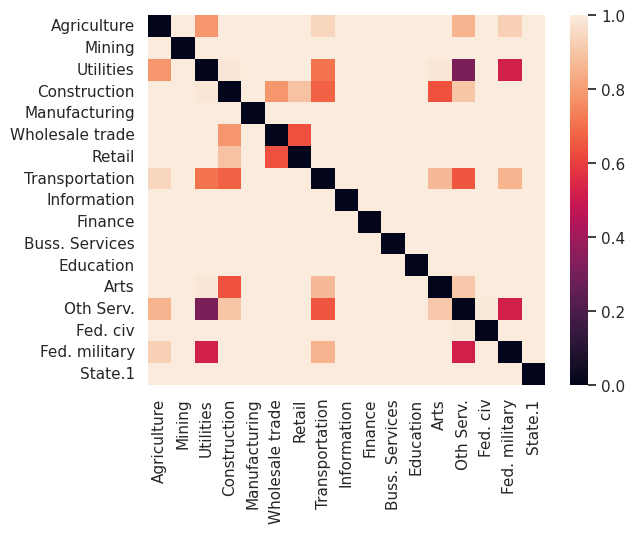

In [22]:
# 2. Compute the similarity matrix
#http://docs.scipy.org/doc/scipy/reference/cluster.html
from scipy import cluster
import sklearn.metrics
dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
matdist= dist.pairwise(features_norm)

# 3.1.1 Visualization
import seaborn as sns; sns.set()
ax = sns.heatmap(matdist,vmin=0, vmax=1, yticklabels = names, xticklabels = names)

Al graficar la matriz de distancia podemos ver que las variables entre si no son demasiado parecidas, es más parece que hay hay cierta variablidad entre ellas salvo ciertos grupos ("parejas") de variables

<ipython-input-23-92467335bf32>:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = cluster.hierarchy.linkage(matdist, method = 'single')


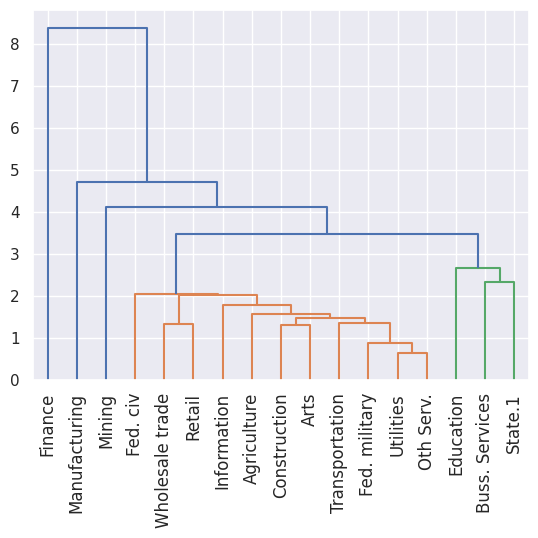

In [23]:
# 3. Building the Dendrogram
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
clusters = cluster.hierarchy.linkage(matdist, method = 'single')
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
cluster.hierarchy.dendrogram(clusters, color_threshold = 3, labels = names , leaf_rotation=90)
plt.show()

Vamos a obtener la asignación de grupos de cada uno de ellos

In [24]:
cut = 3 # !!!! ad-hoc
labels = cluster.hierarchy.fcluster(clusters, cut , criterion = 'distance')

labels

array([1, 3, 1, 1, 4, 1, 1, 1, 1, 5, 2, 2, 1, 1, 1, 1, 2], dtype=int32)

Hemos utilizado Single Link con el propósito de aislar rápidamente aquellos elementos que son outliers y que van a ser las características más significativas, en este caso *Finance*, *Manufacturing* y *Mining*. Luego se distinguen dos grupos, uno de propósito general y otro con *Education*, *Buss. Services*, *State.1*

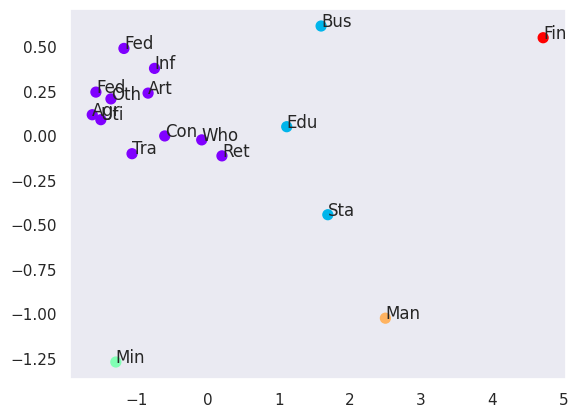

In [25]:
#plotting orginal points with color related to label
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels,s=50, cmap="rainbow")
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], names[i][0:3])

plt.grid()
plt.show()

# DBSCAN



Vamos a identificar elementos outliers mediante la utilización de DBSCAN. El propósito de identificar ouliter es aislar aquellas características que son diferentes a los demás y que nos pueden ayudar a distinguir a los diferentes elementos a los que representan.

### Parametrización


Vamos a fijar MinPts = 2 (en 3 genera uno o ningún cluster), y observar qué epsilon podemos establecer


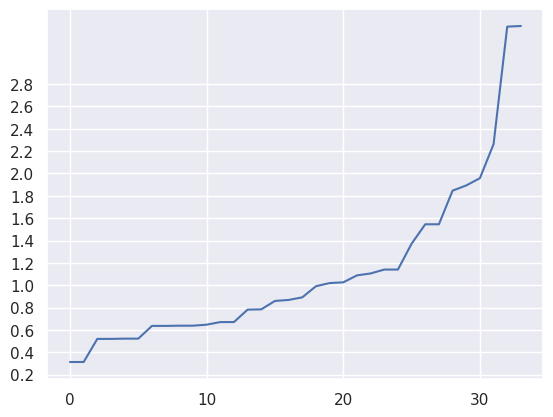

In [26]:
minPts=2
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(features_norm, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(features_norm):
    for j in range(len(features_norm)):
        if Ar[i][j] != 0:
            seq.append(matdist[i][j])

seq.sort()
# establecer intervalo ejes
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 120, 10))
ax.set_yticks(np.arange(0, 3, 0.2))

plt.plot(seq)


plt.show()

Vamos a establecer un rango amplio de pruebas teniendo en cuenta que buscamos aislar elementos diferentes a los demás.

## Ejecución

In [27]:
from sklearn.cluster import DBSCAN

for eps in np.arange(0.50, 1.8, 0.20):
  db = DBSCAN(eps, min_samples=minPts).fit(features_norm)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))

#labels

  0.50, 1, 15
  0.70, 2, 9
  0.90, 1, 8
  1.10, 1, 6
  1.30, 1, 4
  1.50, 1, 3
  1.70, 1, 3


Como podemos observar DBSCAN nos agrupa los elementos en un grupo y el resto son outliers. El número de outliers si es significativo tenerlo en cuenta, por lo que nos vamos a quedar con las parametrizaciones que nos ofrecen un mayor número de outliers.

In [28]:

db = DBSCAN(eps=0.7, min_samples=minPts).fit(features_norm)
labels = db.labels_
labels

array([-1, -1,  0,  0, -1,  1,  1,  0, -1, -1, -1, -1,  0,  0, -1,  0, -1])

Visualizamos los resultados

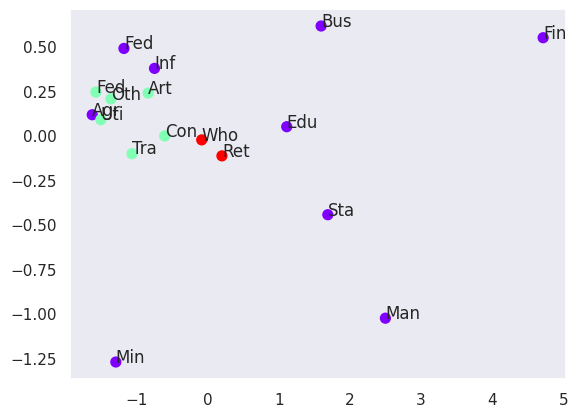

In [29]:
#plotting orginal points with color related to label
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels,s=50, cmap="rainbow")
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], names[i][0:3])
plt.grid()
plt.show()

Y aunque podríamos proceder a su intepretación en este caso lo que vamos a hacer es identificar aquellos elementos que son outliers

In [30]:
df_feat['dbscan_group'] = labels
df_feat[df_feat['dbscan_group'] == -1]

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,dbscan_group
Agriculture,2040,305,1528,2537,25439,2112,314,276,2,5458,...,1386,5964,357,263,1476,5559,186,3089,401,-1
Mining,2982,14327,4687,2249,20279,11330,113,1,0,1278,...,1173,119695,3425,223,2463,687,7502,548,13165,-1
Manufacturing,25444,1867,20026,14010,229479,19429,27665,4732,238,38284,...,38465,153204,15609,2632,36951,47518,6775,45247,1624,-1
Information,4244,948,6559,10864,134655,20171,12134,1210,8073,29121,...,7900,41877,4214,683,16299,32180,1441,7949,449,-1
Finance,25185,5416,51282,14879,406685,45343,69118,23162,11226,161861,...,39924,167303,22879,4973,75490,63201,7935,49183,4233,-1
Buss. Services,16090,2884,27353,8641,236025,34342,25348,5992,24224,85390,...,25587,122764,11461,2176,74156,35749,4264,21309,1408,-1
Education,12957,2757,22549,8432,133118,17061,21758,4075,7659,67777,...,26582,77579,8036,3262,28107,24163,6271,24567,1446,-1
Fed. civ,7174,1882,6247,2326,34009,6900,2488,659,28892,14272,...,7115,21783,3898,745,23877,8832,2744,3346,749,-1
State.1,19746,4929,25123,10494,198300,21580,18668,4945,2604,73926,...,24173,101670,11254,2864,35173,36816,7405,26392,3939,-1
